In [2]:
# Let's import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Create the dataframe with the CSV file provided by the company. As the CSV has missing values, we will use onbad_lines='skip'
df = pd.read_csv('marketingcampaigns.csv', on_bad_lines='skip')

In [4]:
#Display the dataframe
df

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.3,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.1,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.9,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaN,100000,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,abc,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000,0.60,webinar,B2B,paid,0.70,90000.00


In [5]:
# Let's do some basic analysis: such as check the datatypes, the null values and some basic statistics
print('The datatypes of the columns are: ')
print(df.dtypes)
print('\nThe null values in the columns are: ')
print(df.isnull().sum())
print('\nThe basic statistics of the columns are: ')
df.describe().T

The datatypes of the columns are: 
campaign_name       object
start_date          object
end_date            object
budget              object
roi                float64
type                object
target_audience     object
channel             object
conversion_rate    float64
revenue            float64
dtype: object

The null values in the columns are: 
campaign_name      0
start_date         1
end_date           2
budget             3
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
dtype: int64

The basic statistics of the columns are: 


,count,mean,std,min,25%,50%,75%,max
roi,1028.0,0.533804,0.261869,-0.20,0.31,0.53,0.76,0.99
conversion_rate,1028.0,0.541936,0.267353,0.00,0.30,0.55,0.77,1.50
revenue,1029.0,511591.195277,287292.729847,108.21,267820.25,518001.77,765775.14,999712.49


Just by analyzing above data, we can see a few thing we need to take care of:
- We need to make sure that dates are in the correct format (currenly object when it should be datetime).
- We need to make sure budget is in the correct format (currenly object when it should be float).

Before changing anything, let's see what values have the columns that are in the wrong format

In [6]:
# Since budget column should be numeric, let's check if there are any non-numeric values in the Budget column

non_numeric_budget = df[~pd.to_numeric(df['budget'], errors='coerce').notnull()]
print(non_numeric_budget[['budget']])


     budget
1003    NaN
1005    NaN
1024    NaN
1029    abc


In [7]:
# Now let's check date columns. The columns 'start_date' and 'end_date' should be in datetime format. Let's check if they are in the correct format.
non_datetime_start_date	 = df[~pd.to_datetime(df['start_date'], errors='coerce').notnull()]
non_datetime_end_date = df[~pd.to_datetime(df['end_date'], errors='coerce').notnull()]
print(non_datetime_start_date[['start_date']])
print('\n')
print(non_datetime_end_date[['end_date']])

      start_date
1006  2023-13-01
1021         NaN
1022  2023-13-01


        end_date
1006  2024-02-30
1024         NaN
1028         NaN


- Values that are not in the correct format for budget column: 3 nulls and one value which is not part of any of the other columns.
- Values that are not in the correct format for dates columns: 3 nulls, one date which does not exist and 2 dates with the wrong structure (YYY-DD-MM instead of YYYY-MM-DD). 

Knowing this, we can proceed to fix the columns.

In [8]:
# # First step is to check those rows (where the wrong dates are) and check the values so we can take the right decision
df.iloc[[1006, 1022]]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1006,Typo in Date,2023-13-01,2024-02-30,50000.0,0.65,webinar,B2C,promotion,0.9,320000.0
1022,Broken-date campaign,2023-13-01,2024-01-01,25000,0.45,email,B2B,organic,NaN,87500.0


We can see from above table:
- Row 1006: Since the row is fine we take the decision to change the end_date to 2024-03-01. This decision has been taken because is more likely that the end_date is a formula of start_date + X days. We will put the right format on start_date as well.
- Row 1022: Rest of the data is completely fine. We will put the right format on start_date.

In [9]:
# Let's modify the values for rows 1006 and 1022 in "start_date" to get YYYY-MM-DD instead of YYYY-DD-MM 
# and also in row 1006 the value in column end_date to get 2024-03-01 instead of 2024-02-30
df.loc[1006, 'start_date'] = '2024-01-13'
df.loc[1022, 'start_date'] = '2024-01-13'
df.loc[1006, 'end_date'] = '2024-03-01'

Now we can proceed to fix the columns. The only value we will discard in the "abc" on budget column

In [10]:
# Now let's change the format in columns start_date, end_date and budget to the correct format
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

Now, we should have the correct format for all columns. Let's check the datatypes again to make sure everything is in order and also the basic statics we checked before.

In [11]:
print('The datatypes of the columns are: ')
print(df.dtypes)
print('\nThe null values in the columns are: ')
print(df.isnull().sum())
print('\nThe basic statistics of the columns are: ')
df.describe().T

The datatypes of the columns are: 
campaign_name              object
start_date         datetime64[ns]
end_date           datetime64[ns]
budget                    float64
roi                       float64
type                       object
target_audience            object
channel                    object
conversion_rate           float64
revenue                   float64
dtype: object

The null values in the columns are: 
campaign_name      0
start_date         1
end_date           2
budget             4
roi                4
type               1
target_audience    2
channel            1
conversion_rate    4
revenue            3
dtype: int64

The basic statistics of the columns are: 


,count,mean,min,25%,50%,75%,max,std
start_date,1031,2023-01-31 06:29:40.795344384,2022-08-02 00:00:00,2022-10-31 00:00:00,2023-01-29 00:00:00,2023-04-30 00:00:00,2025-01-01 00:00:00,NaN
end_date,1030,2024-01-30 01:49:02.912621312,2022-12-31 00:00:00,2023-11-01 00:00:00,2024-01-27 12:00:00,2024-05-03 18:00:00,2025-06-01 00:00:00,NaN
budget,1028.0,58995.980506,-10000.0,24735.4925,46948.235,74923.65,9999999.0,311694.946084
roi,1028.0,0.533804,-0.2,0.31,0.53,0.76,0.99,0.261869
conversion_rate,1028.0,0.541936,0.0,0.3,0.55,0.77,1.5,0.267353
revenue,1029.0,511591.195277,108.21,267820.25,518001.77,765775.14,999712.49,287292.729847


Now the dataset looks much better, and we have only one more null (the old "abc" value in budget column). 

In [12]:
df

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000.00,0.60,webinar,B2B,paid,0.70,90000.00


Let's check now all values:
- end_date must be after start_date.
- Categoric values must have the correct values (no mixed values).

In [13]:
# Let's check end_date is greater than start_date.
df_dates_check = df[df['end_date'] < df['start_date']]
df_dates_check

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1022,Broken-date campaign,2024-01-13,2024-01-01,25000.0,0.45,email,B2B,organic,NaN,87500.0
1030,Overlapping dates,2023-03-01,2022-12-31,60000.0,0.60,webinar,B2B,paid,0.7,90000.0


So we can see there are two lines where the start_date is after the end_date. Let's check now the categoric values.

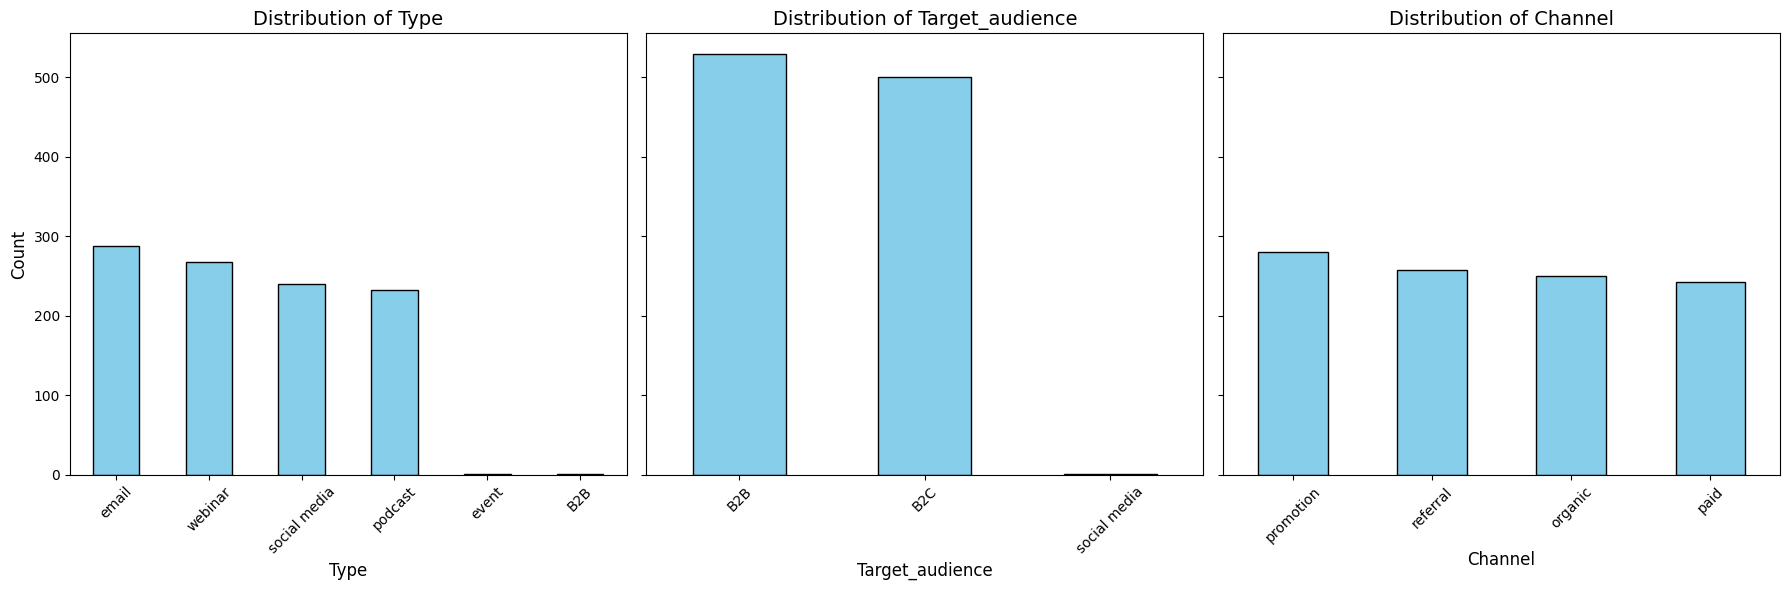

In [14]:
# Let's use a bar plot to visualize the distribution of the categorical columns in the dataset. 
# Then we can focus on those which have a lower number of values to check if they really belong to that column.

categorical_columns = ['type', 'target_audience', 'channel']

fig, axes = plt.subplots(1, len(categorical_columns), figsize=(18, 6), sharey=True)

for i, col in enumerate(categorical_columns):
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col.capitalize()}', fontsize=14)
    axes[i].set_xlabel(col.capitalize(), fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Having a quick look at the date, it is easy to identify some mistakes: there is a "social media" value in the target_audience column and a "B2B" value in the Type column. Also, there is one value in the type column which is used only once: "event".
Let's analyze them

In [15]:
# Let's see the rows with the unique value in column 'type'
df_filtered1 = df[df['type'] == 'event']
df_filtered1

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1021,Cloud-based scalable solution,NaT,2023-12-31,50000.0,NaN,event,B2C,paid,0.3,120000.0


In [16]:
# Let's see the rows with the wrong values in the column 'type'
df_filtered2 = df[df['type'] == 'B2B']
df_filtered2

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1024,Null-heavy campaign,2023-01-01,NaT,NaN,NaN,B2B,social media,NaN,NaN,NaN


We can see that the row which contains the wrong value in the column 'type' is the same that contains the wrong value in the column 'target_audience'.

So far, as a summary, we have:
- 2 rows with the start_date after the end_date.
- 1 row with the values interchanged which is not providing any value at all since the rest of the values are null. Therefore we will drop this row.

In [17]:
# We will drop row 1024
df1 = df.drop(index=1024)

Now let's check if there are duplicated rows.

In [18]:
# Let's check duplicate rows in the dataset
duplicates = df1[df1.duplicated(keep=False)]
duplicates.sort_values(by='campaign_name', ascending=True)

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1001,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
1011,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
11,Cross-platform demand-driven encoding,2023-07-21,2023-11-04,64041.37,0.16,social media,B2B,promotion,0.55,174462.47
1020,Cross-platform demand-driven encoding,2023-07-21,2023-11-04,64041.37,0.16,social media,B2B,promotion,0.55,174462.47
1010,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
1002,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
1012,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73


In [19]:
# Let's count the duplicated rows
duplicates_count = df1.duplicated(keep=False).sum()
duplicates_count

np.int64(27)

We can see 27 duplicated rows. Let's drop them.

In [20]:
# Let's drop the duplicates rows
df2 = df1.drop_duplicates(keep='first')

In [21]:
df2

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1027,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1028,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1029,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00
1030,Overlapping dates,2023-03-01,2022-12-31,60000.00,0.60,webinar,B2B,paid,0.70,90000.00


In [22]:
# Let's see the unique values the categorial columns in the dataset have in order to check if they are consistent
categorical_columns = df2.select_dtypes(include=['object'])

for column in categorical_columns.columns:
    print(f"Unique values in column '{column}':")
    print(categorical_columns[column].unique())
    print()

Unique values in column 'campaign_name':
['Public-key multi-tasking throughput'
 'De-engineered analyzing task-force'
 'Balanced solution-oriented Local Area Network' ... 'Invalid budget'
 'Overlapping dates' 'Too many conversions']

Unique values in column 'type':
['email' 'podcast' 'webinar' 'social media' nan 'event']

Unique values in column 'target_audience':
['B2B' 'B2C' nan]

Unique values in column 'channel':
['organic' 'promotion' 'paid' 'referral']



Now we have a dataset with no duplicates and all columns in the correct format. Let's check the basic statistics again to see what we do with the nulls.

In [23]:
# Let's see the percetange that null values represent by columns
df2.isnull().mean() * 100

campaign_name      0.000000
start_date         0.098425
end_date           0.098425
budget             0.295276
roi                0.295276
type               0.098425
target_audience    0.196850
channel            0.000000
conversion_rate    0.295276
revenue            0.196850
dtype: float64

In [24]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
start_date,1015,2023-01-31 02:36:03.546798080,2022-08-02 00:00:00,2022-10-30 12:00:00,2023-01-29 00:00:00,2023-04-30 00:00:00,2025-01-01 00:00:00,NaN
end_date,1015,2024-01-30 06:52:50.837438720,2022-12-31 00:00:00,2023-11-01 00:00:00,2024-01-28 00:00:00,2024-05-04 00:00:00,2025-06-01 00:00:00,NaN
budget,1013.0,59264.030395,-10000.0,24959.24,47198.52,74898.2,9999999.0,313966.312578
roi,1013.0,0.535084,-0.2,0.31,0.53,0.77,0.99,0.262657
conversion_rate,1013.0,0.543376,0.0,0.3,0.55,0.77,1.5,0.267734
revenue,1014.0,513344.391292,108.21,268474.4725,519906.22,770016.185,999712.49,287623.39894


<Axes: xlabel='revenue'>

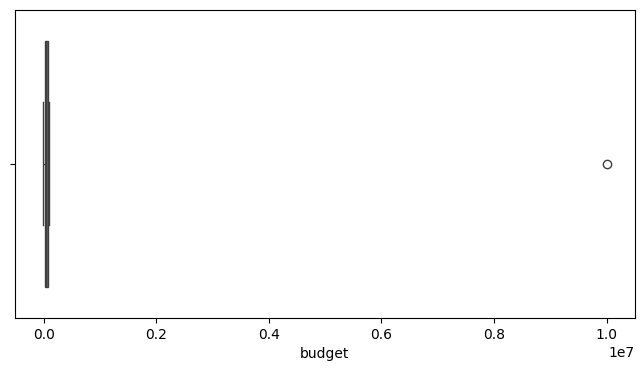

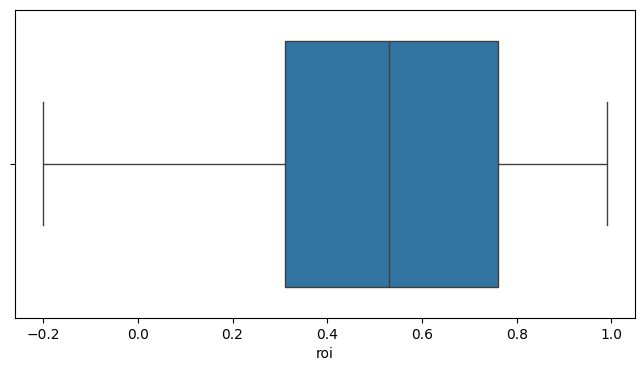

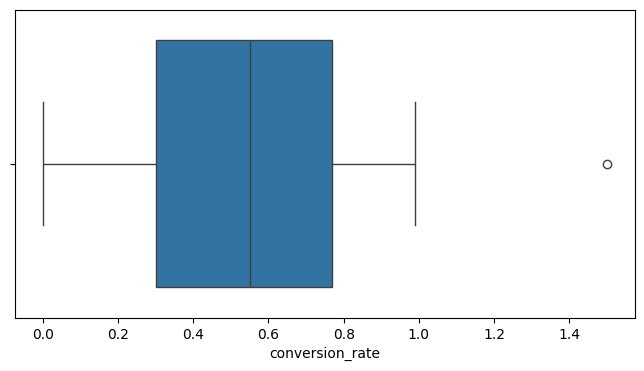

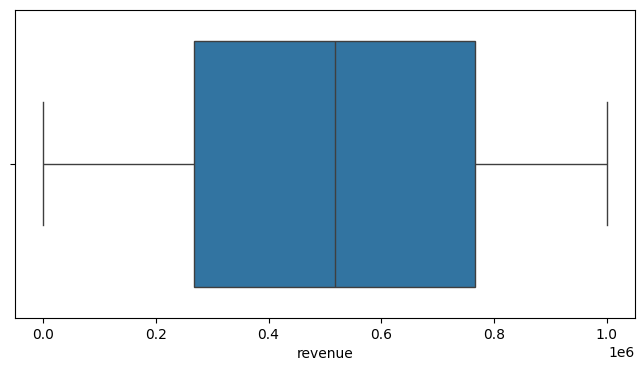

In [25]:
# Generate boxplots for identifying outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['budget'])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['roi'])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['conversion_rate'])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['revenue'])

In [26]:
# Let's reset the index for a better analysis and visualization
df2.reset_index(drop=True, inplace=True)

In [27]:
# With the new index, let's calculate in which rows are the wrong dates
df2_dates_check = df2[df2['end_date'] < df2['start_date']]
df2_dates_check

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1007,Broken-date campaign,2024-01-13,2024-01-01,25000.0,0.45,email,B2B,organic,NaN,87500.0
1014,Overlapping dates,2023-03-01,2022-12-31,60000.0,0.60,webinar,B2B,paid,0.7,90000.0


In [28]:
# Let's check the outliers in column 'budget'
outlier_budget_max = df2[df2['budget'] > 9999998]
outlier_budget_min = df2[df2['budget'] < 1000]
outlier_budget_max

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1005,Outlier Budget,2023-07-01,2024-03-01,9999999.0,0.1,email,B2B,promotion,0.2,50000.0


In [29]:
outlier_budget_min

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1008,Negative ROI test,2022-10-10,2023-05-05,-10000.0,-0.2,podcast,B2C,referral,0.1,NaN


In [30]:
# We can see that the outlier in column 'budget' is for a 'email' type. 
# Let's see which is the mean and the median of the column 'budget' for the type 'email'
mean_budget_email = df2[df2['type'] == 'email']['budget'].mean()
median_budget_email = df2[df2['type'] == 'email']['budget'].median()
print(f'Mean budget for email type: {mean_budget_email}')
print(f'Median budget for email type: {median_budget_email}')

Mean budget for email type: 84933.9060283688
Median budget for email type: 47778.259999999995


If we compare the mean and the meadian with the budget of row 1005, we can see that the value must be an error.
Row 1008 is an error since the budget cannot be negative.

In [31]:
# Let's check the outlier in column 'conversion_rate'
outlier_conversion_rate = df2[df2['conversion_rate'] > 1]
outlier_conversion_rate

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1015,Too many conversions,2023-05-01,2023-11-01,40000.0,0.8,social media,B2C,organic,1.5,120000.0


The fact that there is only 1 row with a conversion_rate above 1 is a good indicator that this value is an error as well.

In [32]:
# Let's see the row with the unique value in column 'type' again
df2_filtered = df2[df2['type'] == 'event']
df2_filtered

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1006,Cloud-based scalable solution,NaT,2023-12-31,50000.0,NaN,event,B2C,paid,0.3,120000.0


In [33]:
#Let's identify the rows with null values in the dataset
null_rows = df2[df2.isnull().any(axis=1)]
null_rows

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1000,Upgradable transitional data-warehouse,2023-06-29,2023-12-13,NaN,0.59,social media,B2C,referral,0.67,558302.11
1001,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1002,NEW CAMPAIGN - Missing Budget,2023-10-01,2024-01-15,NaN,0.25,email,B2B,organic,NaN,45000.00
1006,Cloud-based scalable solution,NaT,2023-12-31,50000.00,NaN,event,B2C,paid,0.30,120000.00
1007,Broken-date campaign,2024-01-13,2024-01-01,25000.00,0.45,email,B2B,organic,NaN,87500.00
1008,Negative ROI test,2022-10-10,2023-05-05,-10000.00,-0.20,podcast,B2C,referral,0.10,NaN
1010,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1011,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1012,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1013,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00


So far we have:
- 2 rows (1007, 1014) with the start_date after the end_date.
- 3 outliers: two in the budget column (1005, 1008) and one in the conversion_rate column (1015).
- 1 unique value (1006) in column 'type'
- 7 rows with null values, excluding the ones alread mentioned with other issues (1000, 1001, 1002, 1010, 1011, 1012, 1013).


In [34]:
#Let's check the is we are missing any outlier in the dataset with the IQR method and the Z-score method.
numeric_columns = ['budget', 'roi', 'conversion_rate', 'revenue']

# IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25) 
    Q3 = data[column].quantile(0.75)  
    IQR = Q3 - Q1  
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    z_scores = (data[column] - mean) / std
    outliers = data[np.abs(z_scores) > threshold]
    return outliers

# Let's check the outliers in the dataset using both methods
for column in numeric_columns:
    print(f"Outliers in column '{column}' using IQR:")
    outliers_iqr = detect_outliers_iqr(df2, column)
    print(outliers_iqr)
    print(f"\nOutliers in column '{column}' using Z-score:")
    outliers_zscore = detect_outliers_zscore(df2, column)
    print(outliers_zscore)
    print("\n")

Outliers in column 'budget' using IQR:
       campaign_name start_date   end_date     budget  roi   type  \
1005  Outlier Budget 2023-07-01 2024-03-01  9999999.0  0.1  email   

     target_audience    channel  conversion_rate  revenue  
1005             B2B  promotion              0.2  50000.0  

Outliers in column 'budget' using Z-score:
       campaign_name start_date   end_date     budget  roi   type  \
1005  Outlier Budget 2023-07-01 2024-03-01  9999999.0  0.1  email   

     target_audience    channel  conversion_rate  revenue  
1005             B2B  promotion              0.2  50000.0  


Outliers in column 'roi' using IQR:
Empty DataFrame
Columns: [campaign_name, start_date, end_date, budget, roi, type, target_audience, channel, conversion_rate, revenue]
Index: []

Outliers in column 'roi' using Z-score:
Empty DataFrame
Columns: [campaign_name, start_date, end_date, budget, roi, type, target_audience, channel, conversion_rate, revenue]
Index: []


Outliers in column 'conversion

The methods are not providing any extra values we need to take care of.

In [35]:
# Let's see all rows with wrong or missing information / outliers in the dataset
df2.iloc[[1000, 1001, 1002, 1005, 1006, 1007, 1008, 1010, 1011, 1012, 1013, 1014, 1015]]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1000,Upgradable transitional data-warehouse,2023-06-29,2023-12-13,NaN,0.59,social media,B2C,referral,0.67,558302.11
1001,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1002,NEW CAMPAIGN - Missing Budget,2023-10-01,2024-01-15,NaN,0.25,email,B2B,organic,NaN,45000.00
1005,Outlier Budget,2023-07-01,2024-03-01,9999999.00,0.10,email,B2B,promotion,0.20,50000.00
1006,Cloud-based scalable solution,NaT,2023-12-31,50000.00,NaN,event,B2C,paid,0.30,120000.00
1007,Broken-date campaign,2024-01-13,2024-01-01,25000.00,0.45,email,B2B,organic,NaN,87500.00
1008,Negative ROI test,2022-10-10,2023-05-05,-10000.00,-0.20,podcast,B2C,referral,0.10,NaN
1010,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1011,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1012,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00


The rows with wrong dates will be dropped because we cannot determine whether the wrong date is the start_date or the end_date. Therefore, we cannot calculate the duration of the campaign or perform any seasonal analysis.
We will drop as well the row with the unique value in the type column since there is no enough information for comparison/analysis.
We will drop as well the outlier with the negative budget since it is not possible to have a negative budget and we don't have a revenue so we can calculate the right budget with the ROI.

In [36]:
# Let's compare the conversion_rate outlier so we can decide if we drop it or modify it

median_conversion_rate = df2[
    (df2['budget'].between(35000, 45000)) &
    (df2['type'] == 'social media') &
    (df2['target_audience'] == 'B2C') &
    (df2['channel'] == 'organic')
]['conversion_rate'].median()

median_conversion_rate

np.float64(0.565)

In [37]:

median_conversion_rate_revenue = df2[
    (df2['budget'].between(35000, 45000)) &
    (df2['type'] == 'social media') &
    (df2['target_audience'] == 'B2C') &
    (df2['channel'] == 'organic')
]['revenue'].median()

median_conversion_rate_revenue

np.float64(742999.9299999999)

After analyzing the median of the conversion_rate and revenue columns, we can see that the outlier in the conversion_rate column is not consistent with the other values in the dataset.
So we will drop it.

For row 1005, the max outlier in the budget column, we will calculate an approx budget since we have the ROI and the revenue.

In [38]:
# Let's drop the above mentioned rows and replace the budget outlier.
df3 = df2.drop([1006, 1007, 1008, 1014, 1015])
df3.loc[1005, 'budget'] = df3.loc[1005,'revenue'] / (1 + df3.loc[1005, 'roi'])
df3.reset_index(drop=True, inplace=True)
df3

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1006,Future campaign,2025-01-01,2025-06-01,75000.00,0.90,webinar,B2C,promotion,0.65,200000.00
1007,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1008,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1009,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00


Now we have a clean dataset without outliers. Let's take care of the nulls.

In [40]:
# Let's identify the nulls per column
df3.isnull().sum()

campaign_name      0
start_date         0
end_date           1
budget             3
roi                2
type               1
target_audience    2
channel            0
conversion_rate    2
revenue            1
dtype: int64

In [41]:
# We have 12 nulls, now let's see the information in the rows with null values
df3[df3.isnull().any(axis=1)]

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
1000,Upgradable transitional data-warehouse,2023-06-29,2023-12-13,NaN,0.59,social media,B2C,referral,0.67,558302.11
1001,User-friendly client-driven service-desk,2023-01-06,2023-12-11,36800.58,0.40,NaN,B2C,promotion,0.52,206241.46
1002,NEW CAMPAIGN - Missing Budget,2023-10-01,2024-01-15,NaN,0.25,email,B2B,organic,NaN,45000.00
1007,Extra long name campaign test,2023-04-15,2023-09-15,30000.00,0.25,email,NaN,paid,0.40,45000.00
1008,No revenue campaign,2023-02-01,2023-08-01,20000.00,0.30,social media,B2B,organic,0.50,NaN
1009,Random mess,2023-06-06,NaT,100000.00,NaN,podcast,NaN,referral,NaN,300000.00
1010,Invalid budget,2022-12-01,2023-06-01,NaN,NaN,email,B2C,promotion,0.20,50000.00


Having a look we can identify the next steps:
- For columns 1000 and 1002, we can calculate the budget since we have the ROI and the revenue.
- For column 1001 we will analyze similar rows to see which is the most likely value.
- For column 1002 we cannot calculate the conversion_rate therefore we will need to check similar rows to decide which value we will put. 
- For column 1007 we will analyze similar rows to see which is the most likely value.
- For column 1008 we will calculate the revenue using the budget and the roi.
- We will drop row 1009 because it has many nulls and we cannot work with it.
- We will drop row 1010 because we cannot work without budget nor ROI.

In [42]:
# Let's do all the changes mentioned above

df4 = df3.drop([1009, 1010])
df4.loc[1000, 'budget'] = df4.loc[1000,'revenue'] / (1 + df4.loc[1000, 'roi'])
df4.loc[1002, 'budget'] = df4.loc[1002,'revenue'] / (1 + df4.loc[1002, 'roi'])
df4.loc[1008, 'revenue'] = df4.loc[1008,'budget'] * (1 + df4.loc[1008, 'roi'])
df4.reset_index(drop=True, inplace=True)
df4

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.300000,0.35,email,B2B,organic,0.40,709593.48
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.980000,0.74,email,B2C,promotion,0.66,516609.10
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.100000,0.37,podcast,B2B,paid,0.28,458227.42
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.750000,0.47,webinar,B2B,organic,0.19,89958.73
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.900000,0.30,social media,B2B,promotion,0.81,47511.35
...,...,...,...,...,...,...,...,...,...,...
1004,Duplicate Campaign,2023-04-01,2024-02-23,8082.300000,0.35,email,B2B,organic,0.40,709593.48
1005,Outlier Budget,2023-07-01,2024-03-01,45454.545455,0.10,email,B2B,promotion,0.20,50000.00
1006,Future campaign,2025-01-01,2025-06-01,75000.000000,0.90,webinar,B2C,promotion,0.65,200000.00
1007,Extra long name campaign test,2023-04-15,2023-09-15,30000.000000,0.25,email,NaN,paid,0.40,45000.00


Let's work now on row 1001 (missing value on column type).

In [44]:
# Filter rows with missing values in the 'type' column
missing_type_row = df4[df4['type'].isnull()]

# Identify similar rows based on other columns
similar_rows = df4[
    (df4['budget'].between(missing_type_row['budget'].values[0] - 5000, missing_type_row['budget'].values[0] + 5000)) &
    (df4['roi'].between(missing_type_row['roi'].values[0] - 0.1, missing_type_row['roi'].values[0] + 0.1)) &
    (df4['target_audience'] == missing_type_row['target_audience'].values[0]) &
    (df4['channel'] == missing_type_row['channel'].values[0])
]

# Find the most frequent value in the 'type' column among similar rows
most_likely_type = similar_rows['type'].mode().values[0]

most_likely_type

'email'

Now we have an answer: email type is the mos likely value row 1001.

In [45]:
# Let's make the chage
df4.loc[1001, 'type'] = most_likely_type

Let's work now on row 1002 (missing value on column conversion_rate).